# Adapting the “Moving Pictures” tutorial from Qiime2 Docs 
(https://docs.qiime2.org/2021.11/tutorials/moving-pictures/)

## 1. Import data
First of all, we donwload the data. This is a python notebook, but we'll be not executing python code, but shell commands. To do so, a "!" must be used in front of each expression. The notebook has been launched from a Qiime2 environment (See 01.setting.up.qiime2.environment.ipynb)
Secondly, in the chunk below, we are going to set the working directory, where all the data inputs and outputs will be stored.
This working dir will be the root for all the subsequent analyses.


In [1]:
%cd /home/david/Desktop/02.qiime2.moving.pictures.extended

/home/david/Desktop/02.qiime2.moving.pictures.extended


In [2]:
! wget -q \
  -O "sample-metadata.tsv" \
  "https://data.qiime2.org/2021.11/tutorials/moving-pictures/sample_metadata.tsv"

The sample metadata contains the relationships between sample names and barcodes

In [3]:
! head sample-metadata.tsv

sample-id	barcode-sequence	body-site	year	month	day	subject	reported-antibiotic-usage	days-since-experiment-start
#q2:types	categorical	categorical	numeric	numeric	numeric	categorical	categorical	numeric
L1S8	AGCTGACTAGTC	gut	2008	10	28	subject-1	Yes	0
L1S57	ACACACTATGGC	gut	2009	1	20	subject-1	No	84
L1S76	ACTACGTGTGGT	gut	2009	2	17	subject-1	No	112
L1S105	AGTGCGATGCGT	gut	2009	3	17	subject-1	No	140
L2S155	ACGATGCGACCA	left palm	2009	1	20	subject-1	No	84
L2S175	AGCTATCCACGA	left palm	2009	2	17	subject-1	No	112
L2S204	ATGCAGCTCAGT	left palm	2009	3	17	subject-1	No	140
L2S222	CACGTGACATGT	left palm	2009	4	14	subject-1	No	168


In [4]:
! mkdir -p emp-single-end-sequences #The -p flag prevents the error if the folder already exists
! wget -q \
  -O "emp-single-end-sequences/barcodes.fastq.gz" \
  "https://data.qiime2.org/2021.11/tutorials/moving-pictures/emp-single-end-sequences/barcodes.fastq.gz"
! wget -q \
  -O "emp-single-end-sequences/sequences.fastq.gz" \
  "https://data.qiime2.org/2021.11/tutorials/moving-pictures/emp-single-end-sequences/sequences.fastq.gz"

In [5]:
! qiime tools import \
  --type EMPSingleEndSequences \
  --input-path emp-single-end-sequences \
  --output-path emp-single-end-sequences.qza

Imported emp-single-end-sequences as EMPSingleEndDirFmt to emp-single-end-sequences.qza


Check the UUID, type, and format

In [6]:
! qiime tools peek emp-single-end-sequences.qza

UUID:        bc2cf36b-3efe-424c-b909-48cd302ac9b8
Type:        EMPSingleEndSequences
Data format: EMPSingleEndDirFmt


## 2. Demultiplexing sequences
To demultiplex sequences we need to know which barcode sequence is associated with each sample. 
This information is contained in the sample metadata file.
We require several inputs:
	- emp-single-end-sequences.qza, generated in the previous step, where barcodes and sequences are present
	- sample-metadata.tsv file, relating barcodes to samples
	- barcode-sequence: name of the column inside the sample-metadata.tsv file where barcode sequences are stored

In [7]:
! qiime demux emp-single \
  --i-seqs emp-single-end-sequences.qza \
  --m-barcodes-file sample-metadata.tsv \
  --m-barcodes-column barcode-sequence \
  --o-per-sample-sequences demux.qza \
  --o-error-correction-details demux-details.qz

Saved SampleData[SequencesWithQuality] to: demux.qza
Saved ErrorCorrectionDetails to: demux-details.qz.qza


We generate a summary of the demultiplexing results

In [8]:
! qiime demux summarize \
  --i-data demux.qza \
  --o-visualization demux.qzv

Saved Visualization to: demux.qzv


All QIIME 2 visualizers (i.e., commands that take a --o-visualization parameter) will generate a .qzv file. You can view these files with qiime tools view

In [9]:
##! qiime tools view demux.qzv

Sequence quality control and feature table construction: the important part of the report is the interactive quality plot, where the quality (phred) score is related to the sequence lenght. This will be helpful for trimming later: somewhere between 100 and 120 nucleotides, the quality drops substantially. 

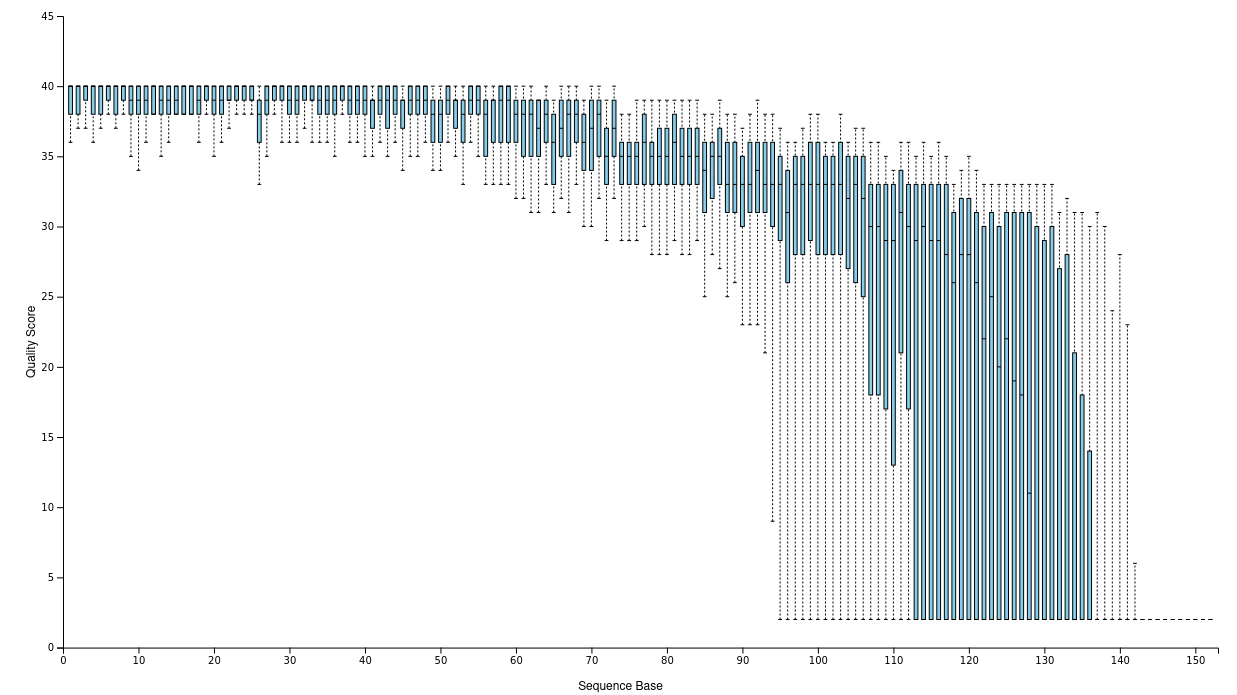

## 3. Sequence quality control and feature table construction
QIIME 2 plugins are available for several quality control methods, including DADA2, Deblur, and basic quality-score-based filtering. 
In this tutorial we present this step using DADA2 and Deblur. These steps are interchangeable, so you can use whichever of these you prefer. 
The result of both of these methods will be a FeatureTable[Frequency] QIIME 2 artifact, which contains:
 - counts (frequencies) of each unique sequence in each sample in the dataset, and 
 - a FeatureData[Sequence] QIIME 2 artifact, which maps feature identifiers in the FeatureTable to the sequences they represent
 
 From the teo options offered in the tutorial, we'll follow the **DADA2** option

The instruction below takes somewhat about one minute to run.
IMPORTANT: https://benjjneb.github.io/dada2/faq.html#can-i-use-dada2-with-my-454-or-ion-torrent-data


In [10]:
! qiime dada2 denoise-single \
  --i-demultiplexed-seqs demux.qza \
  --p-trim-left 0 \
  --p-trunc-len 120 \
  --o-representative-sequences rep-seqs.qza \
  --o-table table.qza \
  --o-denoising-stats stats.qza


Saved FeatureTable[Frequency] to: table.qza
Saved FeatureData[Sequence] to: rep-seqs.qza
Saved SampleData[DADA2Stats] to: stats.qza


In [11]:
! qiime metadata tabulate \
  --m-input-file stats.qza \
  --o-visualization stats.qzv

Saved Visualization to: stats.qzv


## 4. FeatureTable and FeatureData summaries
The feature-table summarize command will give you information on how many sequences are associated with each sample and with each feature, 
histograms of those distributions, and some related summary statistics. 
The feature-table tabulate-seqs command will provide a mapping of feature IDs to sequences, and provide links to easily BLAST each sequence against the NCBI nt database. The latter visualization will be very useful later in the tutorial, 
when you want to learn more about specific features that are important in the data set.


In [12]:
! qiime feature-table summarize \
  --i-table table.qza \
  --o-visualization table.qzv \
  --m-sample-metadata-file sample-metadata.tsv

Saved Visualization to: table.qzv


In [13]:
! qiime feature-table tabulate-seqs \
  --i-data rep-seqs.qza \
  --o-visualization rep-seqs.qzv

Saved Visualization to: rep-seqs.qzv


## 5. Generate a tree for phylogenetic diversity analyse


In [14]:
! qiime phylogeny align-to-tree-mafft-fasttree \
  --i-sequences rep-seqs.qza \
  --o-alignment aligned-rep-seqs.qza \
  --o-masked-alignment masked-aligned-rep-seqs.qza \
  --o-tree unrooted-tree.qza \
  --o-rooted-tree rooted-tree.qza

Saved FeatureData[AlignedSequence] to: aligned-rep-seqs.qza
Saved FeatureData[AlignedSequence] to: masked-aligned-rep-seqs.qza
Saved Phylogeny[Unrooted] to: unrooted-tree.qza
Saved Phylogeny[Rooted] to: rooted-tree.qza


## 6. Alpha and beta diversity analysis


In [15]:
! rm -rf core-metrics-results  # If the dir exists, it's removed

! qiime diversity core-metrics-phylogenetic \
  --i-phylogeny rooted-tree.qza \
  --i-table table.qza \
  --p-sampling-depth 1103 \
  --m-metadata-file sample-metadata.tsv \
  --output-dir core-metrics-results

Saved FeatureTable[Frequency] to: core-metrics-results/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: core-metrics-results/evenness_vector.qza
Saved DistanceMatrix to: core-metrics-results/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: core-metrics-results/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: core-metrics-results/jaccard_distance_matrix.qza
Saved DistanceMatrix to: core-metrics-results/bray_curtis_distance_matrix.qza
Saved PCoAResults to: core-metrics-results/unweighted_unifrac_pcoa_results.qza
Saved PCoAResults to: core-metrics-results/weighted_unifrac_pcoa_results.qza
Saved PCoAResults to: core-metrics-results/jaccard_pcoa_results.qza
Saved PCoAResults to: core-metrics-results/bray_curtis_pcoa_re